In [3]:
import seaborn as sea
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KernelDensity
import numpy as py
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [4]:
file_name = '../measurements_haskell.csv'        
df = pd.read_csv(file_name, header = 0, delimiter=",", decimal=".", names=['Language','Program','PowerLimit','Package','Core','GPU','DRAM','Time','Temperature','Memory'])
print(df.describe())

       PowerLimit     Package        Core          Time  Temperature  \
count  600.000000  600.000000  600.000000    600.000000   600.000000   
mean    34.833333   79.968531   65.439080   5815.533333    47.456167   
std     39.446998   36.868270   35.433136   3792.926025     5.360222   
min     -1.000000   27.580322   14.568604   2069.000000    37.000000   
25%      5.000000   53.751160   38.114441   3068.250000    42.600000   
50%     22.500000   70.322906   60.032043   5102.500000    50.200000   
75%     45.000000  100.188461   80.541397   7605.250000    51.700000   
max    115.000000  195.075623  173.410522  22491.000000    54.900000   

            Memory  
count   600.000000  
mean   6032.266667  
std     144.356943  
min    5120.000000  
25%    5920.000000  
50%    6080.000000  
75%    6080.000000  
max    6240.000000  


#### Comparar PowerLimit e Package só do real/grep

<Axes: xlabel='PowerLimit', ylabel='Package'>

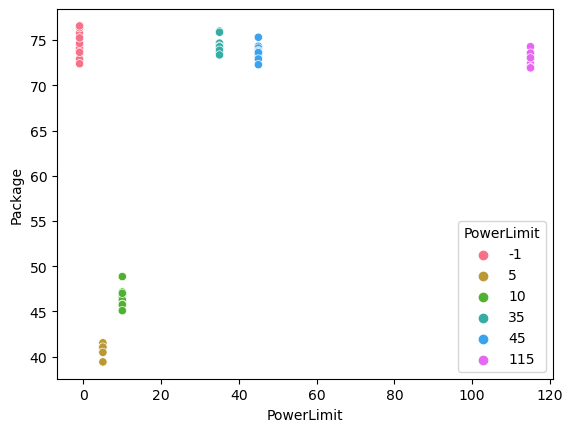

In [5]:
# Filter the DataFrame for one specific program (e.g., 'real/grep')
program_df = df[df['Program'] == ' real/grep']

custom_palette = sea.color_palette("husl", n_colors=len(program_df['PowerLimit'].unique()))

# Create the scatterplot
sea.scatterplot(data=program_df, hue='PowerLimit', x='PowerLimit', y='Package', palette=custom_palette)
# program_df


#### Comparar PowerLimit e Package de todos

<Axes: xlabel='PowerLimit', ylabel='Package'>

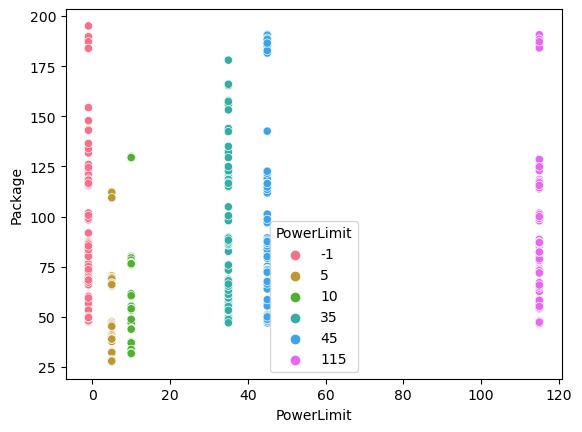

In [6]:
# Filter the DataFrame for one specific program (e.g., 'real/grep')
custom_palette = sea.color_palette("husl", n_colors=len(program_df['PowerLimit'].unique()))

# Create the scatterplot
sea.scatterplot(data=df, hue='PowerLimit', x='PowerLimit', y='Package', palette=custom_palette)
# program_df

#### Box Plots para todos os benchmarks

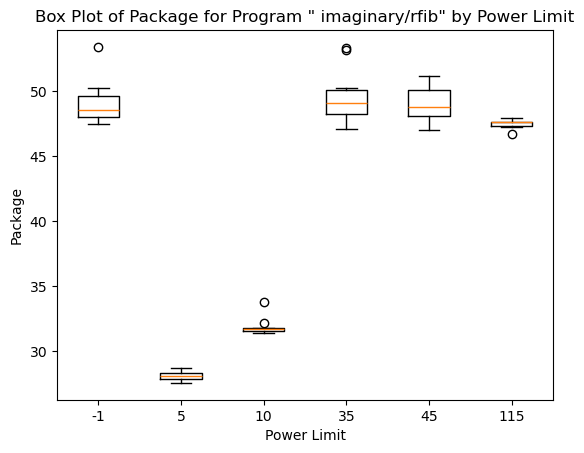

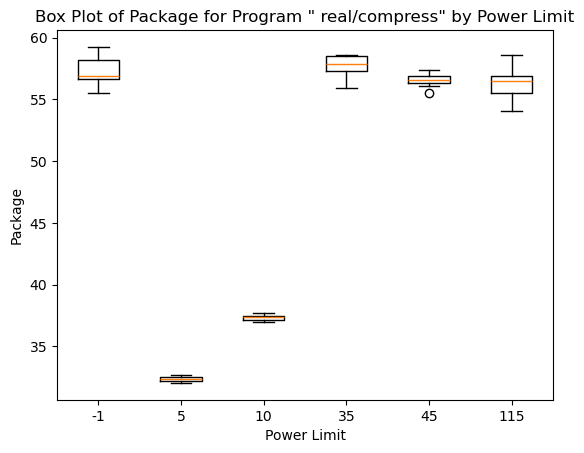

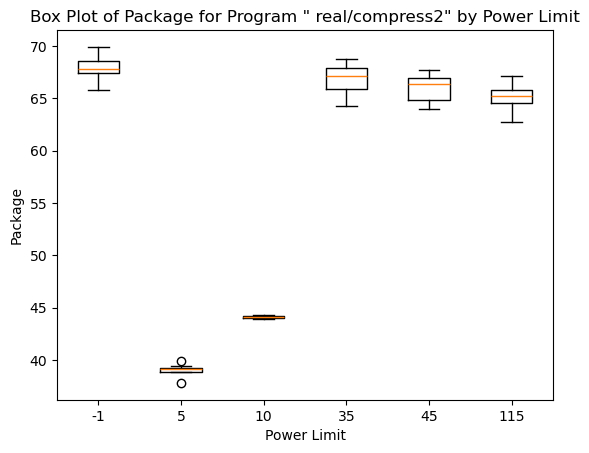

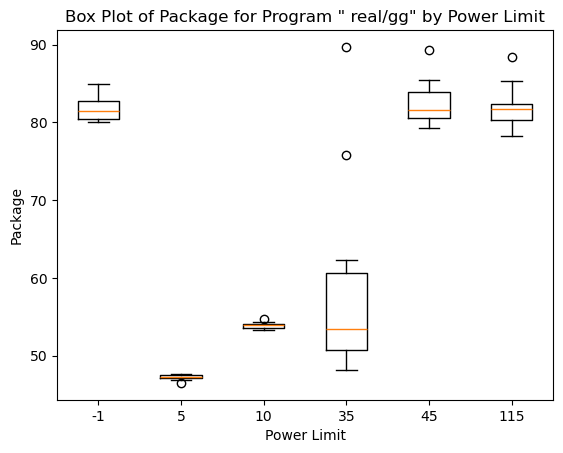

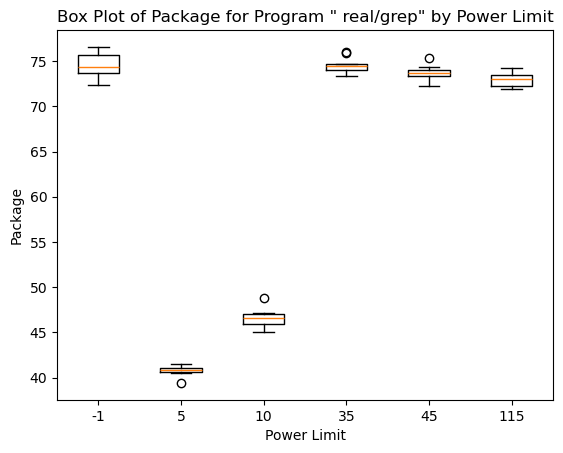

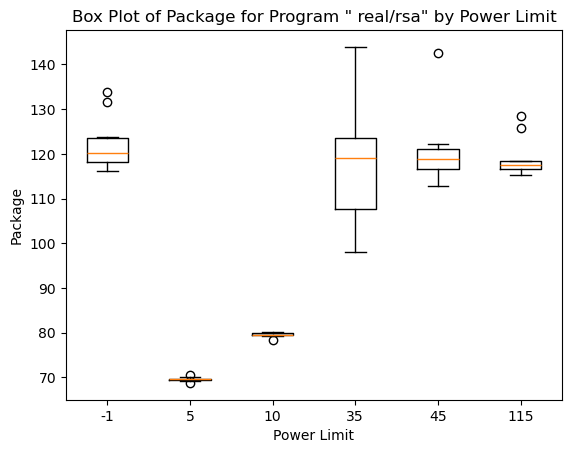

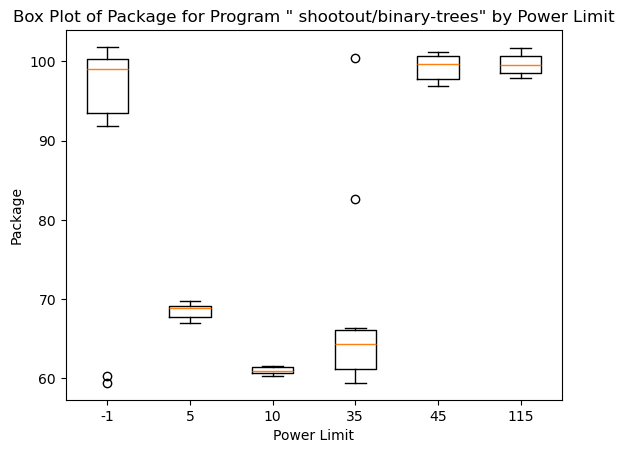

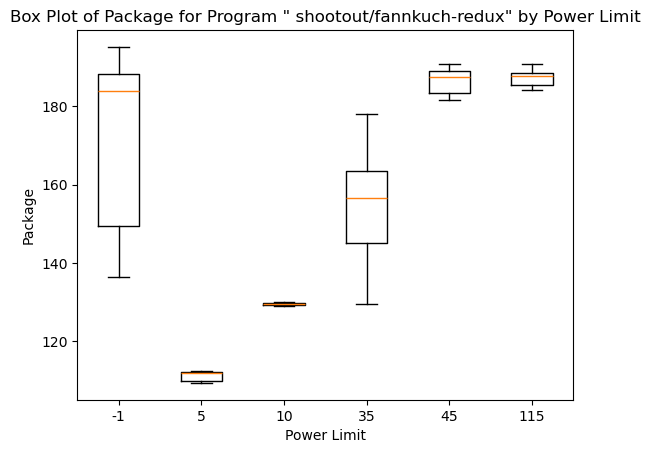

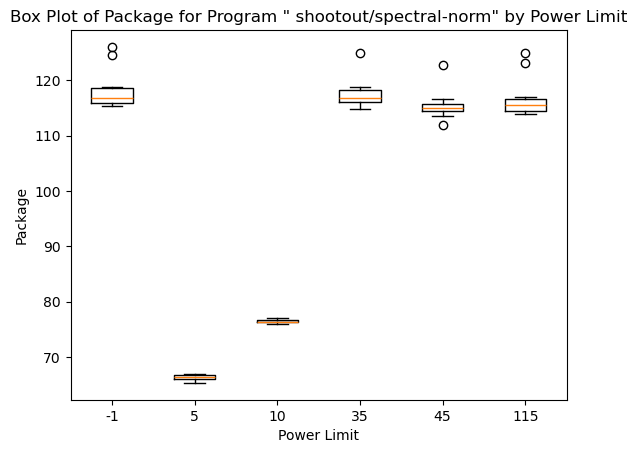

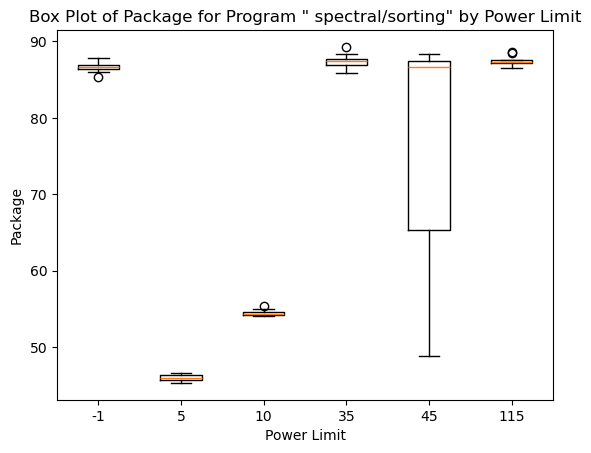

In [7]:
# Iterate over each program group
groups = df.groupby('Program')
def show_box_plot(groups):
    for name, program_group in groups:
        # Group the program group by power limit
        power_groups = program_group.groupby('PowerLimit')
        
        # Create an empty list to store the data for each power limit
        data = []
        
        # Extract data for each power limit and store it in the list
        for power, power_group in power_groups:
            data.append(power_group['Package'])
        
        
        # Create a box plot for each power limit for the current program
        plt.boxplot(data, labels=power_groups.groups.keys())
        plt.xlabel('Power Limit')
        plt.ylabel('Package')
        plt.title(f'Box Plot of Package for Program "{name}" by Power Limit')
        plt.show()

show_box_plot(groups)

In [8]:
grouped_df = df.groupby(['Program', 'PowerLimit'])

def remove_outliers(group):
    Q1 = group['Time'].quantile(0.25)
    Q3 = group['Time'].quantile(0.75)
    IQR = Q3 - Q1
    mask = (group['Time'] >= (Q1 - 1.5 * IQR)) & (group['Time'] <= (Q3 + 1.5 * IQR))
    return group[mask]


cleaned_df = grouped_df.apply(remove_outliers).reset_index(drop=True)
#groups = cleaned_df.groupby('Program')
#show_box_plot(groups)

#### Density Estimation

<Axes: xlabel='Package', ylabel='Count'>

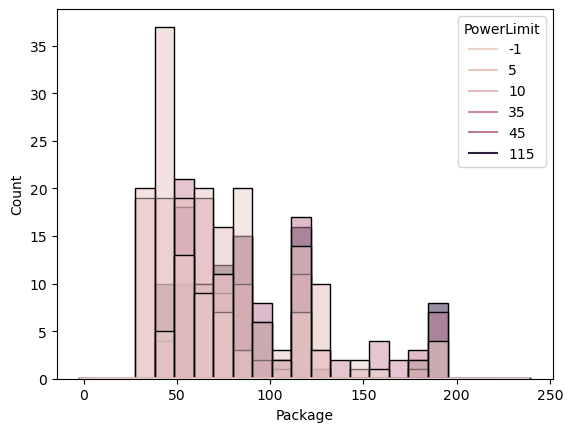

In [9]:
sea.histplot(data=cleaned_df, hue='PowerLimit', x='Package')
sea.kdeplot(data=cleaned_df, hue='PowerLimit', x='Package')

## Correlação entre Variáveis

##### real_gg (sem powercap -1, se não o gráfico fica errado)

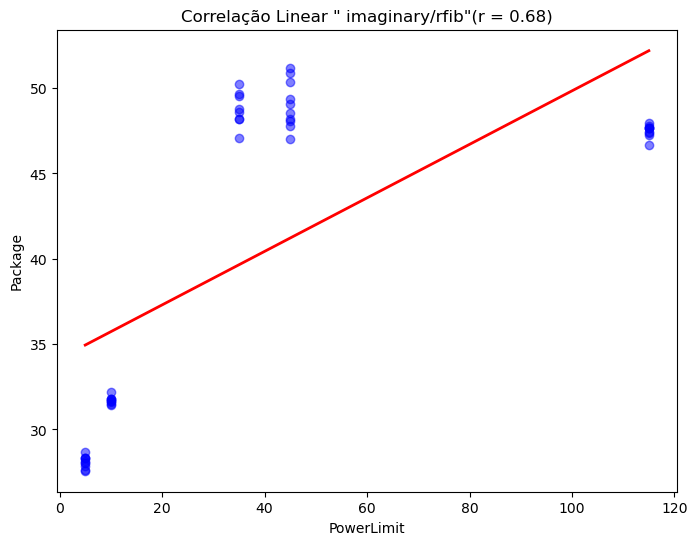

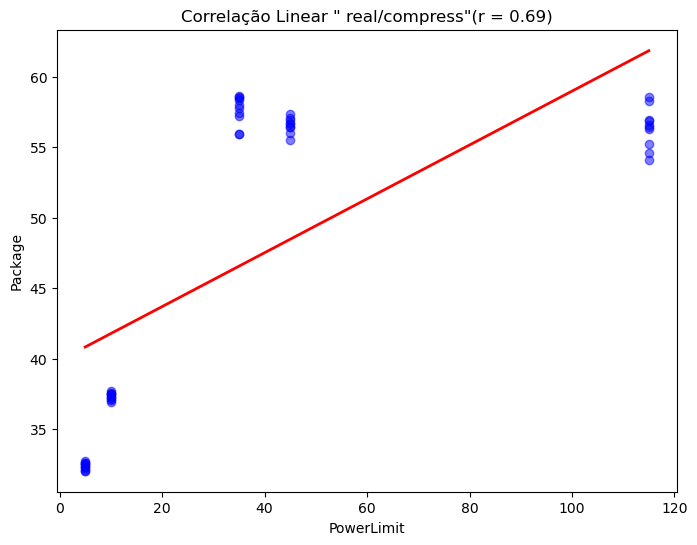

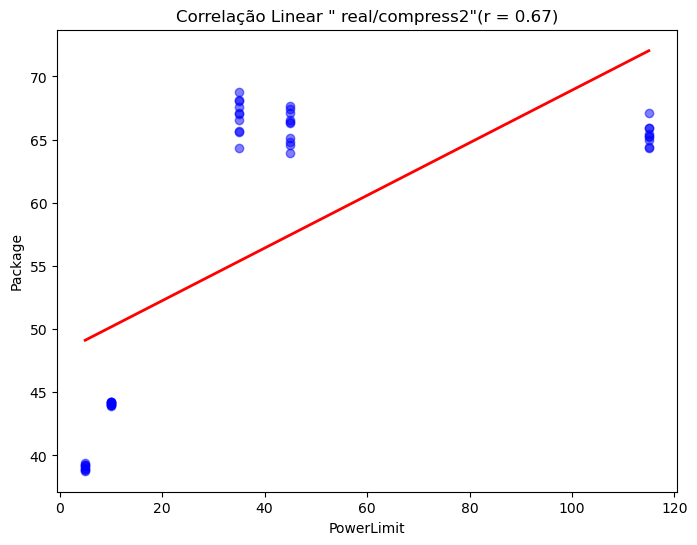

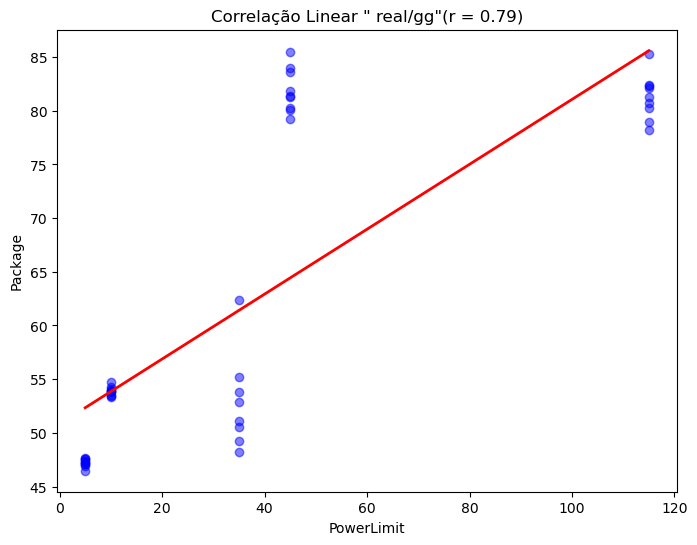

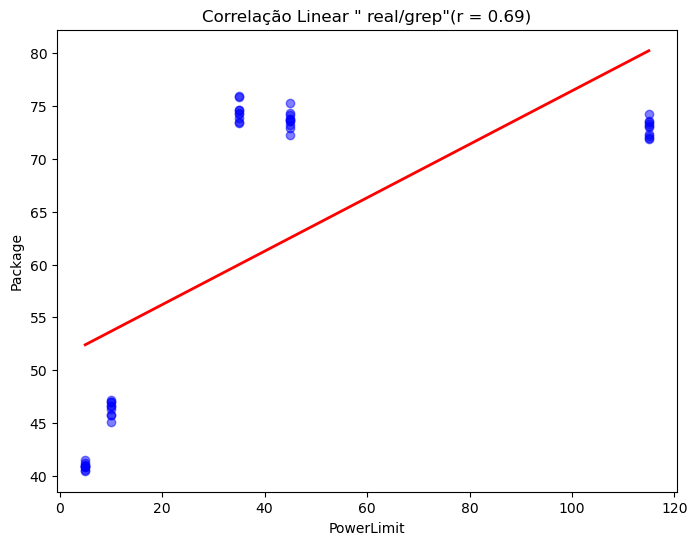

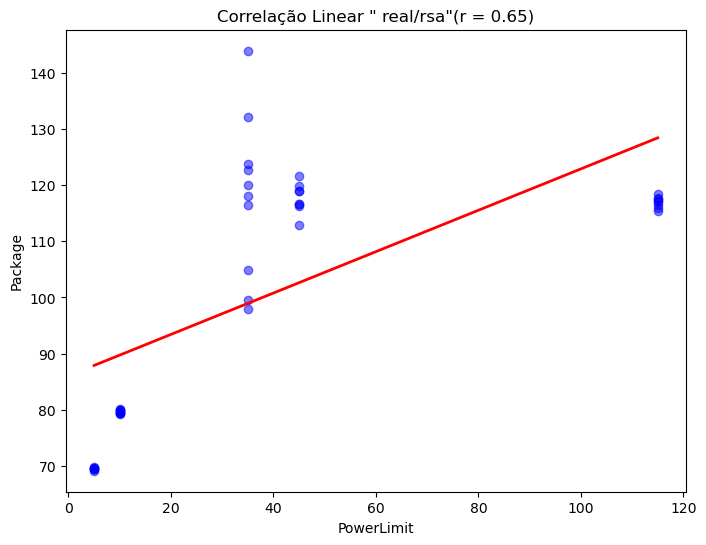

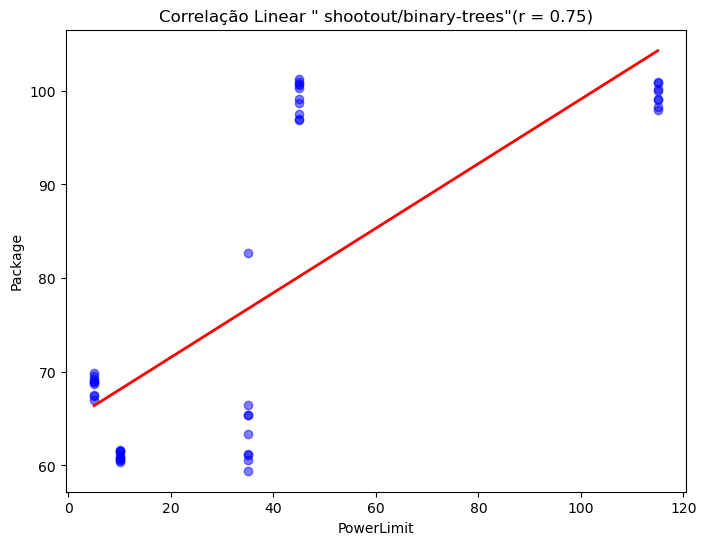

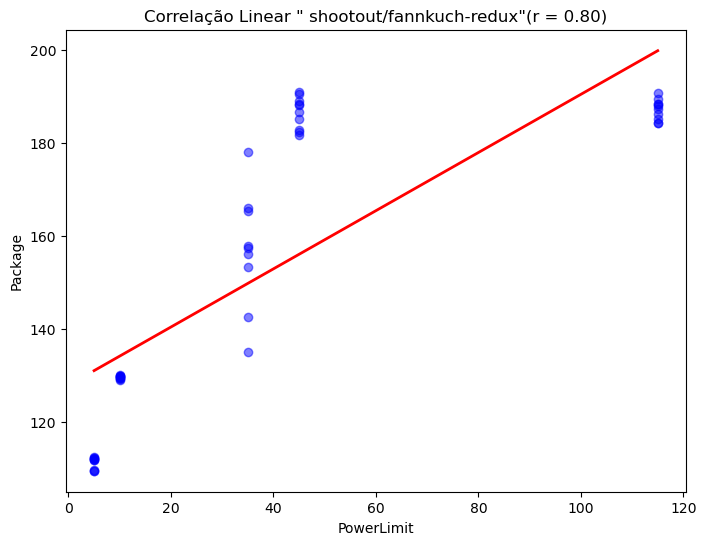

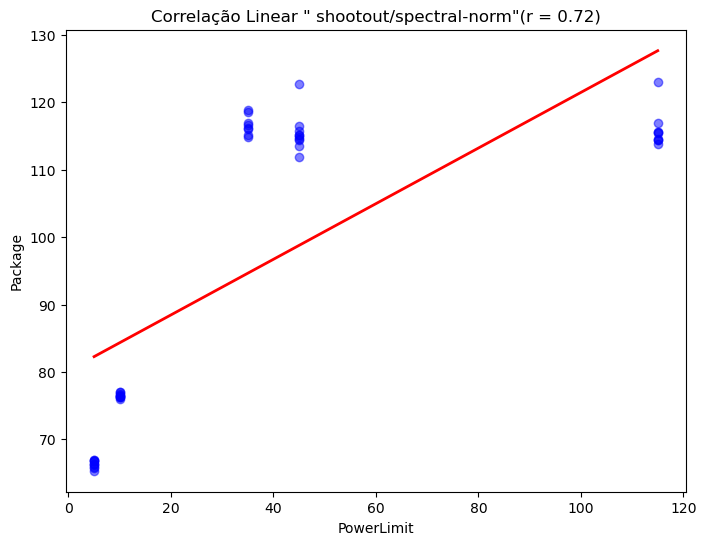

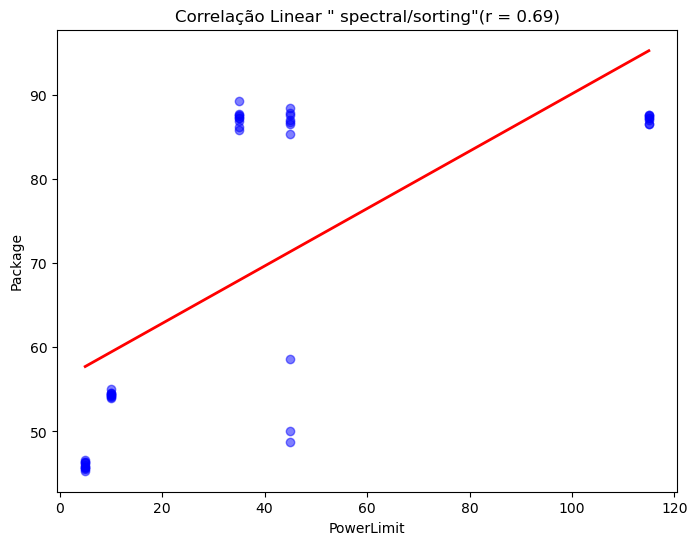

In [10]:
#file_nameh1 = 'measurements_haskell.csv'        
#dfh1 = pd.read_csv(file_nameh1, header = 0, delimiter=",", decimal=".", names=['Language','Program','PowerLimit','Package','Core','GPU','DRAM','Time','Temperature','Memory'])
cleaned_df2 = cleaned_df
dfh1 = cleaned_df2[cleaned_df2['PowerLimit'] != -1]
groups = dfh1.groupby('Program')


def show_corr_linear(groups):
    for name, program_group in groups:

        

        # Criando o gráfico de dispersão
        plt.figure(figsize=(8, 6))
        plt.scatter(program_group['PowerLimit'], program_group['Package'], color='blue', alpha=0.5)

        # Adicionando a linha de regressão linear
        slope, intercept, r_value, p_value, std_err = stats.linregress(program_group['PowerLimit'], program_group['Package'])
        plt.plot(program_group['PowerLimit'], slope * program_group['PowerLimit'] + intercept, color='red', linewidth=2)

        plt.xlabel('PowerLimit')
        plt.ylabel('Package')
        plt.title(f'Correlação Linear "{name}"(r = '+'{:.2f})'.format(r_value))
        plt.show()


show_corr_linear(groups)


### Teste de 1. **Pearson**

In [11]:
def calculate_correlations(group):
    # 1. **Pearson** correlation
    Pearson_corr, Pearson_p = stats.pearsonr(group['Time'], group['PowerLimit'])
    
    # **Spearman** correlation
    Spearman_corr, Spearman_p = stats.spearmanr(group['Time'], group['PowerLimit'])
    
    # 3. **Kendall** Tau correlation
    Kendall_corr, Kendall_p = stats.kendalltau(group['Time'], group['PowerLimit'])
    
    # Return results in a DataFrame format for easier concatenation
    return pd.DataFrame({
        'Program': [group['Program'].iloc[0]],
        'Pearson': [Pearson_corr],
        'Pearson_p': [Pearson_p],
        'Spearman': [Spearman_corr],
        'Spearman_p': [Spearman_p],
        'Kendall': [Kendall_corr],
        'Kendall_p': [Kendall_p]
    })

# Remove rows with PowerLimit = -1 because it has no powercap 
cleaned_df3 = cleaned_df[cleaned_df['PowerLimit'] != -1]

#print(cleaned_df3.groupby(['Program',"PowerLimit"]).count())
# Group by 'Program' and apply the correlation calculation function
correlation_results = cleaned_df3.groupby('Program').apply(calculate_correlations).reset_index(drop=True)

# Print the correlation results
print(correlation_results)

                    Program   Pearson     Pearson_p  Spearman    Spearman_p  \
0            imaginary/rfib -0.619736  3.399128e-06 -0.762414  4.761172e-10   
1             real/compress -0.605655  4.009439e-06 -0.740572  1.182101e-09   
2            real/compress2 -0.583656  1.661145e-05 -0.703957  3.386223e-08   
3                   real/gg -0.667350  4.079684e-07 -0.859102  2.192666e-14   
4                 real/grep -0.617411  3.787592e-06 -0.874752  9.317308e-16   
5                  real/rsa -0.589905  3.934330e-05 -0.822290  2.426276e-11   
6     shootout/binary-trees -0.616114  4.021767e-06 -0.892823  3.405101e-17   
7   shootout/fannkuch-redux -0.623484  1.706813e-06 -0.914660  4.091015e-20   
8    shootout/spectral-norm -0.614130  4.406050e-06 -0.801716  1.275885e-11   
9          spectral/sorting -0.608822  7.142516e-06 -0.696073  7.838895e-08   

    Kendall     Kendall_p  
0 -0.608433  2.623789e-08  
1 -0.573197  8.287650e-08  
2 -0.546353  5.951941e-07  
3 -0.677439  9.135

### Correlation Analysis between `PowerLimit` && `Package`

Important Note: values with powerlimit -1 were removed because it means no powerlimit was applied

#### Program: imaginary/rfib
1. **Pearson**: -0.619736, p-value = 3.399128e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.762414, p-value = 4.761172e-10
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.608433, p-value = 2.623789e-08
    - Moderate negative association, statistically significant.

#### Program: real/compress
1. **Pearson**: -0.605655, p-value = 4.009439e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.740572, p-value = 1.182101e-09
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.573197, p-value = 8.287650e-08
    - Moderate negative association, statistically significant.

#### Program: real/compress2
1. **Pearson**: -0.583656, p-value = 1.661145e-05
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.703957, p-value = 3.386223e-08
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.546353, p-value = 5.951941e-07
    - Moderate negative association, statistically significant.

#### Program: real/gg
1. **Pearson**: -0.667350, p-value = 4.079684e-07
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.859102, p-value = 2.192666e-14
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.677439, p-value = 9.135221e-10
    - Moderate negative association, statistically significant.

#### Program: real/grep
1. **Pearson**: -0.617411, p-value = 3.787592e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.874752, p-value = 9.317308e-16
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.743782, p-value = 9.721644e-12
    - Moderate negative association, statistically significant.

#### Program: real/rsa
1. **Pearson**: -0.589905, p-value = 3.934330e-05
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.822290, p-value = 2.426276e-11
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.691919, p-value = 2.374662e-09
    - Moderate negative association, statistically significant.

#### Program: shootout/binary-trees
1. **Pearson**: -0.616114, p-value = 4.021767e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.892823, p-value = 3.405101e-17
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.739418, p-value = 1.248874e-11
    - Moderate negative association, statistically significant.

#### Program: shootout/fannkuch-redux
1. **Pearson**: -0.623484, p-value = 1.706813e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.914660, p-value = 4.091015e-20
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.792452, p-value = 1.145026e-13
    - Moderate negative association, statistically significant.

#### Program: shootout/spectral-norm
1. **Pearson**: -0.614130, p-value = 4.406050e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.801716, p-value = 1.275885e-11
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.643448, p-value = 3.800222e-09
    - Moderate negative association, statistically significant.

#### Program: spectral/sorting
1. **Pearson**: -0.608822, p-value = 7.142516e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.696073, p-value = 7.838895e-08
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.544260, p-value = 8.567240e-07
    - Moderate negative association, statistically significant.

## Conclusion

When the Powerlimit grows the Package increases in each benchmark, proven throughout this notebook. 

This proves the initial hypothesis that Powercap caps the resource usage which makes us conclude that the lower the value in the Powerlimit the higher the power limitation.